## This notebook is developed for PICES 2022

### CODAR

CODAR is a technology that allows the measurement of surface ocean current velocities at a distance using the Doppler shift of reflected radio waves. The principle of Bragg scattering dictates that virtually all of the radio signal received by a CODAR antenna is being reflected back from ocean waves of a particular wavelength. The reflected signal is Doppler-shifted to higher or lower frequencies, depending on whether the ocean wave is moving, respectively, toward or away from the antenna. In the absence of ocean currents, this Doppler shift gives a measurement of the wave spee. If ocean currents are present, however, the Doppler shift gives a measurement of the wave speed PLUS the speed of the ocean current towards or away from the antenna. Because the speed of deep-water waves is known for a given wavelength, the wave speed can be subtracted from the total measured speed, resulting in a value for the speed of the ocean current alone.

The strait of Georgia CODAR system used by ONC is a 25 MHz model. A radio frequency of 25 MHz corresponds to a radio wavelength of 12 meters, so the CODAR system is sensitive to ocean wavelengths of 6 meter. The equation used in calculating ocean current velocities from the Bragg-scattering signal assume that the ocean waves being measured are "deep-water" waves. In other words, their wavelengths are less than twice the water depth. As depth decreases beyong this point, the waves will increasingly take on the character of "shallow-water" waves. Thus that for a 25 MHz system, ocean currents measured in water depths of less than 3 meters should be viewd with suspiction.  


### CODAR stations and combiners

Each CODAR systems measures the radial velocities of ocean surface currents, toward and away from the station's attenna. Four stations (VCOL, VION, VGPT, VATK) in the Strait of Georgia  have been placed in locations such that their areas of coverage overlap considerably. In the overlapping regions, it is possible to combine the radial data from at least two stations into total ocean currents. 

In the strait of Georgia, four antennas have been gradually installed since 2011. 


Note that the range of high-frequency radio waves is greatly reduced over fresh water compared to the range over salty, highly-conductive water. For this reason, during the spring freshet (June 2018), when the surface water in the strait of Gerogia is much less sality, less coverage of total ocean current would be expected.


### Grid

The total files organize the data into grids with y,x and time dimensions, while the radials files use arrays for the current data, with dimensions of time and index, where index links the currents to their lat/lon sampling locations. The x,y dimensions are the grid centers relative to the grid origin.

The radial files from combiner stations will contain data from multiple radials stations; the platform_name variable will supply the station name / call sign (i.e. VION) for each time step. 


### Data description

MAT file data structures and definitions

This section describes the MAT file structure in detail. HFRProgs's README and code also documents these structures, so only relevant ones will be listed in detail.

**Totals**

1. U/V: surface current total velocities calculated from the Radials structure
2. LonLat,2 vector containing longitude and latitude pairs for each U/V value
3. Timestamp: date in number format.

### Data included: June and Nov. 2018 of total vectors in formats of *.mat 


In [1]:
from hdf5storage import savemat
from hdf5storage import loadmat
import os
from datetime import timedelta  
import scipy.stats as stats
import matplotlib.mlab as mlab
from matplotlib.pyplot import cm
import matplotlib
import matplotlib.pyplot as plt
import numpy.matlib
import numpy.ma as ma
import numpy as np
import glob
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import pandas as pd
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib nbagg
cmap = matplotlib.cm.jet

In [ ]:
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac


def vector_log(U_raw,V_raw):
    SpeedL=np.log10(np.sqrt(U_raw**2+V_raw**2))
    Theta=np.arctan(V_raw/U_raw)
    UL=np.sign(U_raw)*SpeedL*np.abs(np.cos(Theta))
    VL=np.sign(V_raw)*SpeedL*np.abs(np.sin(Theta))
    return UL, VL    

def plotBasemap(Latmin,Latmax,Lonmin,Lonmax,Title):   
    
    M=Basemap(projection='merc', llcrnrlat=Latmin,urcrnrlat=Latmax,llcrnrlon=Lonmin,
              urcrnrlon=Lonmax,resolution='h',area_thresh = 0.01)    
    
    M.drawparallels(np.arange(48.85,49.37,0.1) ,labels=[1,0,0,0]);
    M.drawmeridians(np.arange(-123.8,-122.95,0.3),labels=[0,0,0,1]);
    M.drawmapboundary()
    M.fillcontinents(color='grey')
    
    
    plt.title(Title)
    Stationnames=['VION','VGPT','VATK','VCOL'] 
    for i,Istation in enumerate((Stationnames)):
        XO,YO=M(orig_lon[Istation],orig_lat[Istation])
        M.plot(XO,YO,'r^',markersize=10)
        plt.text(XO,YO,Istation,fontsize=14)
        plt.title(Title,fontsize=14)
    return M    

In [168]:
# Get data files for the specific month and set up your own basedir 
month='Nov'
basedir='/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/'
datafolder=basedir+'Data_PICES2022/'+month+'2018_totals_mat'
datafiles=sorted(glob.glob(datafolder+'/*.mat'))
savefigurefolder=basedir+'savefigures/'+month+'/'

In [169]:
datafiles

['/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181101T000000.000Z_20181115T210000.000Z-Totals_Radials_Clean.mat',
 '/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181115T220000.000Z_20181130T050000.000Z-Totals_Radials_Clean.mat',
 '/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181130T060000.000Z_20181130T230000.000Z-Totals_Radials_Clean.mat']

In [173]:
# Longitude and latitude of the four radar sites for plotting sites
orig_lon={}
orig_lat={}

orig_lon['VION']=-123.2053833
orig_lon['VCOL']=-123.1718833
orig_lon['VGPT']=-123.291
orig_lon['VATK']=-123.2644333
orig_lon['VDIG']=-130.4254500
orig_lon['VRID']=-130.3346833

orig_lat['VATK']=49.3300667
orig_lat['VCOL']=49.01805
orig_lat['VGPT']=48.87365
orig_lat['VION']=49.2158667
orig_lat['VDIG']=54.2625333
orig_lat['VRID']=54.2346333

#basemap boundary
stationnames=['VION','VGPT','VATK','VCOL'] 
latmin = 48.85
latmax = 49.39
lonmin =-123.8
lonmax =-122.9

latpar_min=round(latmin*10)//10
latpar_max=round(latmax*10)//10
lonpar_min=round(lonmin*10)//10
lonpar_max=round(lonmax*10)//10

In [172]:
# load three mat files for the specific month and then 
u=[]
v=[]
date=[]
for i in range(len(datafiles)):
    print (i)
    print (datafiles[i])
    datai=loadmat(datafiles[i])
    num_hours=len(datai['Totals'])
    for j in range(num_hours):
        
        #get u and v
        dataj=datai['Totals'][j][0]
        uj=dataj['U']
        vj=dataj['V']
        u=np.append(u,uj)
        v=np.append(v,vj)
        
        #get date
        timestamp=dataj['TimeStamp'][0][0]+0.0000000001
        datej=str(matlab2datetime(np.float(timestamp)))[0:13]
        date=np.append(date,datej)
    # get lon and lat    
    lonlat=dataj['LonLat']
    

0
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181101T000000.000Z_20181115T210000.000Z-Totals_Radials_Clean.mat
1
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181115T220000.000Z_20181130T050000.000Z-Totals_Radials_Clean.mat
2
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181130T060000.000Z_20181130T230000.000Z-Totals_Radials_Clean.mat


In [174]:
# Put u and v into Pandas dataframe
lon=lonlat[:,0]
lat=lonlat[:,1]
num_hours=len(date)
u_df=pd.DataFrame(u.reshape(num_hours,len(u)//num_hours).T,index=[lon,lat],columns=date)
v_df=pd.DataFrame(v.reshape(num_hours,len(u)//num_hours).T,index=[lon,lat],columns=date)

In [175]:
u_df

,,2018-11-01 00,2018-11-01 01,2018-11-01 02,2018-11-01 03,2018-11-01 04,2018-11-01 05,2018-11-01 06,2018-11-01 07,2018-11-01 08,2018-11-01 09,...,2018-11-30 14,2018-11-30 15,2018-11-30 16,2018-11-30 17,2018-11-30 18,2018-11-30 19,2018-11-30 20,2018-11-30 21,2018-11-30 22,2018-11-30 23
-123.015064,48.788191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.001455,48.788148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.987846,48.788104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.919804,48.787858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.906195,48.787804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-123.741076,49.426560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.727292,49.426604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.713508,49.426645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.699723,49.426685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1) Temporal availability

Every hour has different number of grid points that has available data. Before any use of these data, it will be helpful to check the availability.

<IPython.core.display.Javascript object>


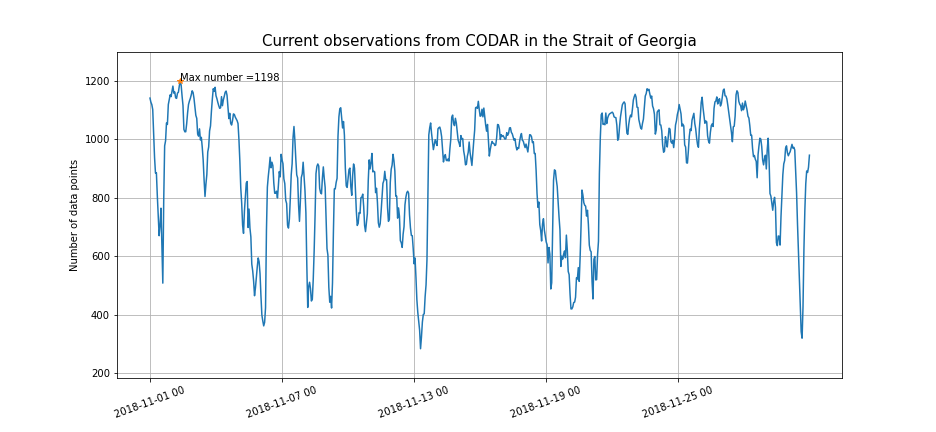

In [176]:
# Plot available number of data grid points

#mask nans with 0, and available values with 1
maskU_df=u_df
maskU_df=maskU_df.notnull().astype("int");
num_datapoints=maskU_df.sum(axis=0).values

#plot
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(13,6))
ax=[]

xt=np.arange(len(num_datapoints))
plt.plot(xt,num_datapoints)

# find the timestamp that has the maximum number of data points
plt.plot(np.argmax(num_datapoints),num_datapoints[np.argmax(num_datapoints)],'*')
plt.text(np.argmax(num_datapoints),num_datapoints[np.argmax(num_datapoints)],'Max number ='+str(np.max(num_datapoints)))

tick_freq=len(xt)//5; #5 xtick labels
plt.xticks(xt[::tick_freq],date[::tick_freq],rotation=20,fontsize=10);
plt.ylabel('Number of data points',fontsize=10);
plt.title('Current observations from CODAR in the Strait of Georgia',fontsize=15);
plt.grid('on'); plt.ylim([np.min(num_datapoints)-100,np.max(num_datapoints)+100]);

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TemporalAvailability_'+str(month)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# 2) Spatial Availability 

Spatial availability=number of available hours/total hours of that month

<IPython.core.display.Javascript object>


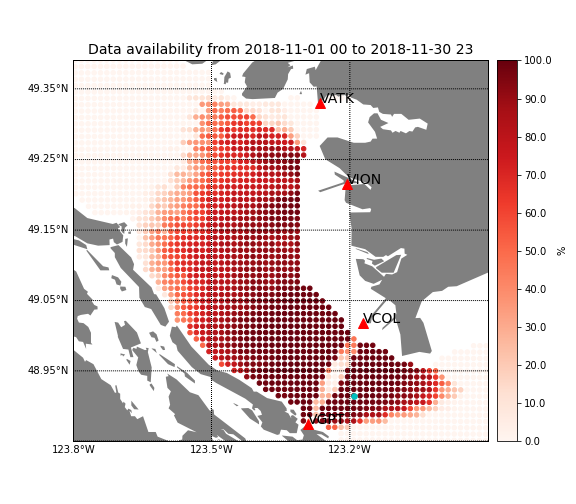

In [189]:
spatial_availability=maskU_df.sum(axis=1)/maskU_df.shape[1]
max_spatial_avail=np.argmax(spatial_availability)  # any other cells can define here

cell_num=max_spatial_avail

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,7))
ax=[]
mSOG=plotBasemap(latmin,latmax,lonmin,lonmax,'Data availability from '+date[0]+' to '+date[-1])


q=plt.scatter(lons,lats,c=spatial_availability.values*100,s=20,cmap='Reds')

cb=mSOG.colorbar(label='%' );
q.set_clim(np.array([0,100.001]))
cb.set_ticks(np.arange(0,100.001,10))
cb.set_ticklabels(np.arange(0,100.001,10))

plt.scatter(lons[cell_num],lats[cell_num],30, marker='o', color='c')


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='SpatialAvailability_'+str(month)+'_cell'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

<IPython.core.display.Javascript object>


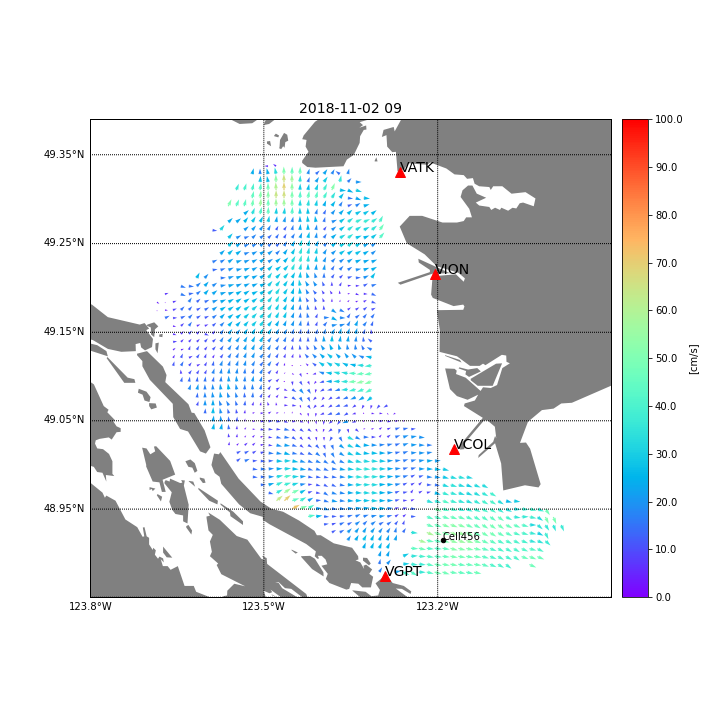

In [190]:
# Plot the total currents that has maximum data coverage during that month


maxIndex_num_datapoints=np.argmax(num_datapoints)
u_select=u_df.iloc[:,maxIndex_num_datapoints]
v_select=v_df.iloc[:,maxIndex_num_datapoints]

#plot
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10))
ax=axs
mSOG=plotBasemap(latmin,latmax,lonmin,lonmax,date[maxIndex_num_datapoints])
lons,lats=mSOG(lon,lat)

#log scale u and v
u,v=vector_log(u_select,v_select)
#plot vectors
q=mSOG.quiver(lons,lats,u,v,np.sqrt(u_select**2+v_select**2),units='x',cmap=cm.rainbow)
cbar=mSOG.colorbar(q,ticks=np.arange(0,101,10),format = '%2.1f',label='[cm/s]')
q.set_clim(np.array([0,100]))
plt.scatter(lons[cell_num],lats[cell_num],20, marker='o', color='black')
plt.text(lons[cell_num],lats[cell_num],'Cell'+str(cell_num))


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TotalCurrent_'+date[maxIndex_num_datapoints]+str(month)+'_cell'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#


# 3) spectral analysis

1. select one grid cell, which has maximum spatial data avaialability
2. rotary spectra analysis for u and v


In [191]:
#need to adjust nfft based on the length of the data

u_cell=u_df.iloc[cell_num,:].values
v_cell=v_df.iloc[cell_num,:].values

# Interpolate u and v since mlab.psd cannot bear nans

u_interp=np.interp(np.arange(len(u_cell)), 
          np.arange(len(u_cell))[np.isnan(u_cell) == False], 
          u_cell[np.isnan(u_cell) == False])

v_interp=np.interp(np.arange(len(v_cell)), 
          np.arange(len(v_cell))[np.isnan(v_cell) == False], 
          v_cell[np.isnan(v_cell) == False])


#normalize u and v
u_cell_norm=(u_interp-np.mean(u_interp))/np.std(u_interp)
v_cell_norm=(v_interp-np.mean(v_interp))/np.std(v_interp)
vel_cell_norm=u_cell_norm+1j*v_cell_norm

#calculate spectra of velocity
ndata=len(u_cell)
nfft=256
dof=2*ndata/nfft-1
Cus,kk=mlab.psd(vel_cell_norm,Fs=1./1,NFFT=nfft,window=mlab.window_hanning,noverlap=nfft/2)

<IPython.core.display.Javascript object>


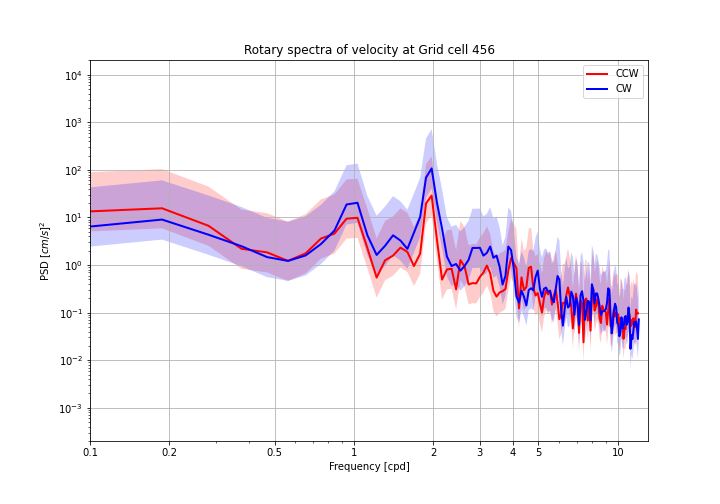

In [192]:
#plot rotary spectra, 

# def function of pltfill to plot the uncertainty based on degrees of freedom
def pltfill(X,Y,DOF,Col):
    Inter=stats.chi2.interval(0.95,df=DOF)
    plt.fill_between(X,DOF*(Y)/Inter[1],DOF*(Y)/Inter[0],alpha=0.2,
        linewidth=0.0,edgecolor=None,color=Col,facecolor=Col)
       

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,7))
ax=[]

#Plot ccw
plt.plot(kk*24,Cus,label='CCW',color='r',linewidth=2);pltfill(kk*24,Cus,dof,'r')

#Plot cw
plt.plot(-kk*24,Cus,label='CW',color='blue',linewidth=2);pltfill(-kk*24,Cus,dof,'blue');

plt.grid(); plt.yscale('log'); plt.xscale('log');
plt.legend(); plt.xlabel(''); plt.xlim([0.1,13]); plt.ylim([0.0002,20000]);
plt.title('Rotary spectra of velocity at Grid cell '+str(cell_num));
plt.xticks([0.1,0.2,0.5,1,2,3,4,5,10],[0.1,0.2,0.5,1,2,3,4,5,10]);
plt.xlabel('Frequency [cpd]');plt.ylabel('PSD '+'$[cm/s]^2$');

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='RotarySpectra_Cell'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# 4) PCA analysis


Sources

https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Steps of calculating PCA: 

1. Subtract the mean of each value;
2. Calculate the Covariance Matrix: The covariance matrix is a square matrix donoting the covariance of elements with each other. The covariance of an element with itself is nothing but just its variance;
3. Compute the eigenvalues and eigenvectors:

    3.1 The eigenvectors of the covariance matrix we get are orthononal to each other and each vector represents a principle axis;    
    3.2 A higher eigenvalue corresponds to a higher variability. Hence the principal axis with the higher eigenvalue will be an axis captuting higher variability in the data;    
    3.3 Orthogonal means the vectors are mutually perpendicular to each other; 
    
4. Sort eigenvalues in descending order:

    4.1 Sort the eigenvalues in the descending order along with their corrsponding eigenvectors;    
    4.2 Each column in the eigen vector-matrix corresponds to a principal compoment, so arranging them in desciending order of their eigenvalue will automatically arrange the principal component in desciending order of their variability;    
    4.3 So the first column in the rearranged eigen vector-matrix will be a principle compionent that captures the highest variability.
    
5. Select a subset from the rearraged eigenvalue matrix

6. Transform the data. Transform the data by having a dot product between the transpose of the eigenvector subset and the transpose of the mean-centered data. 


PC actually is the direction with variance scaled. Direction can be decided by the eigenvectors of covariance. 

In [193]:
#Input UU and VV data time series at a certain grid cell in format of dataframe
def pca_data(UU,VV,N_std):
    XX=pd.DataFrame({'u':UU,'v':VV}).values
    XX_meaned=XX-np.mean(XX,axis=0)
    Ppca=PCA(n_components=2).fit(XX_meaned)
    
    Angle=np.arctan(Ppca.components_[0,1]/Ppca.components_[0,0])*180/np.pi+180
    Ellipse_norm=N_std*np.sqrt(Ppca.explained_variance_)* Ppca.components_.T #normalized by number of N_std
    Ell_radius_x=np.sqrt(Ellipse_norm[0,0]**2+Ellipse_norm[1,0]**2)
    Ell_radius_y=np.sqrt(Ellipse_norm[0,1]**2+Ellipse_norm[1,1]**2)
       
    return XX_meaned,Angle,Ell_radius_x,Ell_radius_y,Ppca

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1,v0, arrowprops=arrowprops)
    
def plot_ellipse_grid(PCA,N_std,X_demeaned,Ellipse_x,Ellipse_y,Angle,Tit,Col):

    plt.scatter(X_demeaned[:, 0], X_demeaned[:, 1], color=Col,alpha=0.2,label='De_meaned')    
    e = Ellipse(xy = (0,0), width = Ellipse_x * 2, height = Ellipse_y * 2, angle=Angle,
           edgecolor='blue',facecolor='none',joinstyle='bevel',
                     linewidth=1)

    for Length, Vector in zip(PCA.explained_variance_, PCA.components_):
        VV = Vector  * np.sqrt(Length)*N_std
        draw_vector(PCA.mean_, PCA.mean_ +VV)
    
    
    Label_x=-100+13;Label_y=100-13;Scale=5
    e2 = Ellipse(xy = (Label_x,Label_y), width =Scale*2, height =Scale*2, angle=90,
               edgecolor=Col,facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                         linewidth=1)
    plt.plot([Label_x,Label_x+Scale],[Label_y,Label_y],color='black')
    ax.add_artist(e2);plt.text(Label_x-Scale-Scale/2,Label_y+Scale+Scale/2,'5cm/s') 
    
    ax.add_artist(e);plt.xlim([-100,100]);plt.ylim([-100,100])
    ax.legend(loc=3,fontsize=8)
    ax.set_xlabel('U [cm/s]',fontsize=11)
    ax.set_ylabel('V [cm/s]',fontsize=11)
    plt.axvline(x = 0,color='black',alpha=0.3)
    plt.axhline(y = 0,color='black',alpha=0.3)
    plt.text(75,-50,'$2\sigma$',fontsize=15);plt.title(Tit)

<IPython.core.display.Javascript object>


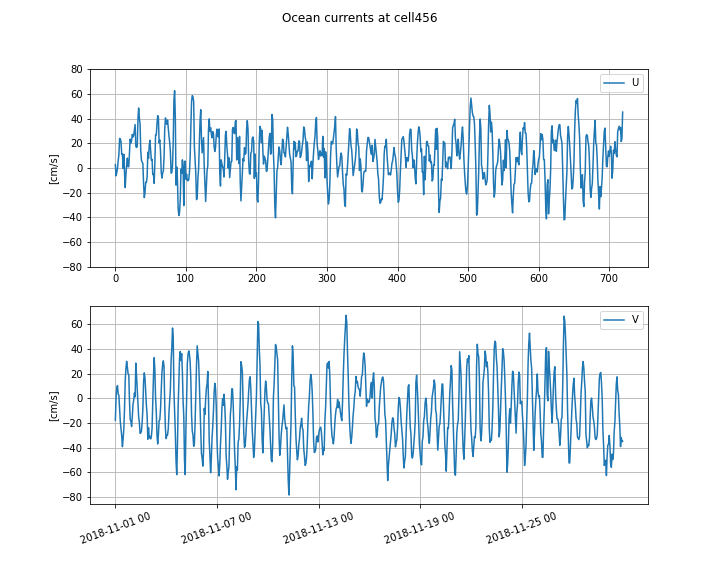

In [194]:
# select u and v from one of the grid cells.
u_cell=u_df.iloc[cell_num,:]
v_cell=v_df.iloc[cell_num,:]

fig, axs = plt.subplots(2,figsize=(10,8))
fig.suptitle('Ocean currents at cell'+str(cell_num))


axs[0].plot(xt,u_cell,label='U')
axs[0].legend();axs[0].set_ylim([-70,70]);
axs[0].grid('on'); axs[0].set_ylabel('[cm/s]',fontsize=10);


axs[1].plot(xt,v_cell,label='V')
axs[1].legend();axs[0].set_ylim([-80,80]);
axs[1].grid('on');

plt.xticks(xt[::tick_freq],date[::tick_freq],rotation=20,fontsize=10);
axs[1].set_ylabel('[cm/s]',fontsize=10);


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='UV_cell'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

<IPython.core.display.Javascript object>


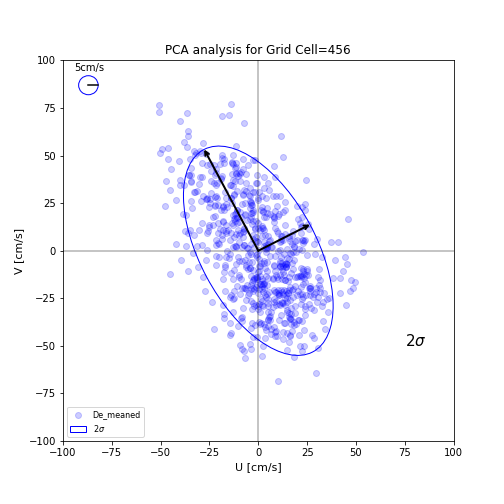

In [195]:
# pca analysis
u_cell_nonan=u_cell.dropna()
v_cell_nonan=v_cell.dropna()

n_std=2
U_meaned_cell,angle_cell,ell_x_cell,ell_y_cell,pca_cell=pca_data(u_cell_nonan,v_cell_nonan,n_std)


fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs
plot_ellipse_grid(pca_cell,n_std,U_meaned_cell,ell_x_cell,
                              ell_y_cell,angle_cell,'PCA analysis for Grid Cell='+str(cell_num),'blue')


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='PCA_Cell'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# 5) Save one grid cell data and then load into matlab to run t-tide 

In [184]:
#ttide can bear nan values
Vel={'U':u_cell.values,'V':v_cell.values}
if not os.path.exists(basedir+'ttide_data_'+str(month)):
    os.makedirs(basedir+'ttide_data_'+str(month))
savemat(basedir+'ttide_data_'+str(month)+'/uv_cell.mat',Vel)

# 6) Calculate and plot the tidal analysis for one grid/site [u,v]


In [196]:
# Load tidal analysis results
outvar=['fmaj','emaj','fmin','emin','finc','einc','pha','epha']

tide_datafolder=basedir+'ttide_data_'+month+'/'+'cell'+str(cell_num)+'/'
tidecons=loadmat(tide_datafolder+'tidecons.mat')['tidecon']
tidenames=loadmat(tide_datafolder+'tidename.mat')['nameu'].tolist()
tide=loadmat(tide_datafolder+'tides.mat')
u_tide=np.real(tide['xout'])[0]
v_tide=np.imag(tide['xout'])[0]

In [197]:
#######
# load major, minor and angle of ellipse
tide_plot=['M2  ','S2  ','K1  ','O1  ']
ellipse_major={}
ellipse_minor={}
rotation={}

for icon, con_name in enumerate(tide_plot):
    index_tide=tidenames.index(con_name)
    
    ellipse_major[con_name]=tidecons[index_tide,outvar.index('fmaj')]
    ellipse_minor[con_name]=tidecons[index_tide,outvar.index('fmin')]
    rotation[con_name]=tidecons[index_tide,outvar.index('finc')]
# if negative, CW; if postive, CCW
ellipse_minor

{'M2  ': -7.238162896251286,
 'S2  ': -1.6647979136140805,
 'K1  ': -1.4218928393595727,
 'O1  ': 0.4947022330810342}

<IPython.core.display.Javascript object>


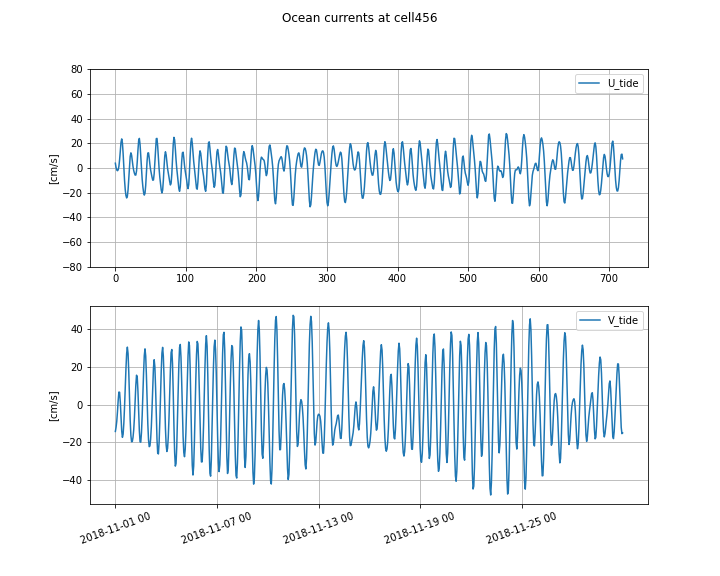

In [198]:
# plot u and v tide
fig, axs = plt.subplots(2,figsize=(10,8))
fig.suptitle('Ocean currents at cell'+str(cell_num))


axs[0].plot(xt,u_tide,label='U_tide')
axs[0].legend();axs[0].set_ylim([-70,70]);
axs[0].grid('on'); axs[0].set_ylabel('[cm/s]',fontsize=10);


axs[1].plot(xt,v_tide,label='V_tide')
axs[1].legend();axs[0].set_ylim([-80,80]);
axs[1].grid('on');

plt.xticks(xt[::tick_freq],date[::tick_freq],rotation=20,fontsize=10);
axs[1].set_ylabel('[cm/s]',fontsize=10);


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='UV_tide'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

<IPython.core.display.Javascript object>


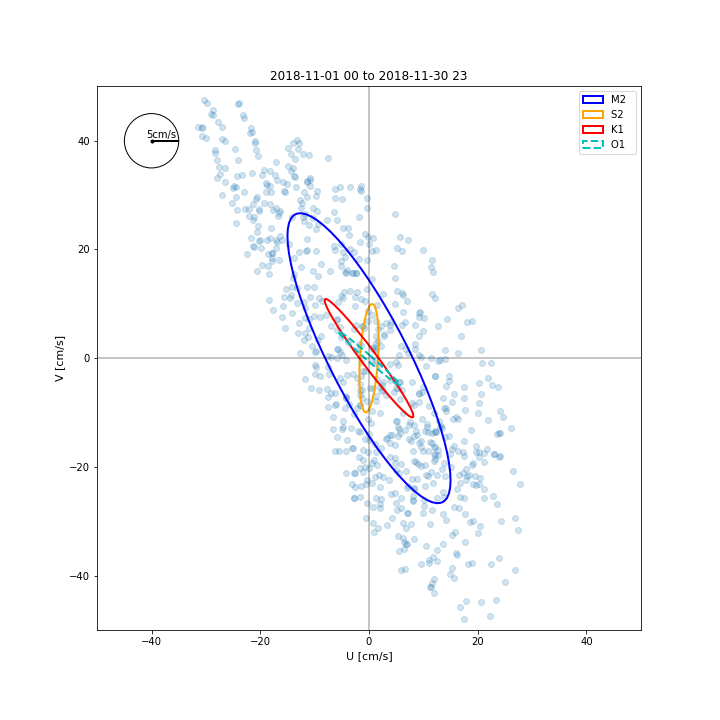

In [199]:
# Plot preparation
xcenter=0
ycenter=0
colors=['blue','orange','red','c']
u_tide_demeamed=u_tide-np.mean(u_tide)
v_tide_demeamed=v_tide-np.mean(v_tide)

# Plot ellipse
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10))
ax=axs
plt.scatter(u_tide_demeamed,v_tide_demeamed, alpha=0.2,)


#'M2'
itide=0
e1 = Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2)
ax.add_artist(e1)

#'S2'
itide=1
e2 = Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2)
ax.add_artist(e2)

#'K1'
itide=2
e3= Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2)
ax.add_artist(e3)

#'O1'
itide=3
e4 = Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2,linestyle='--')
ax.add_artist(e4)
ax.legend([e1,e2,e3,e4],tide_plot)

# Plot measurement
cc=plt.Circle((-40,40),5,fill=False)
ax.set_aspect( 1 ) 
ax.add_artist( cc ) 
plt.plot(-40,40,'.',color='black')
ax.hlines(y=40, xmin=-40, xmax=-35, linewidth=2, color='black')
ax.text(-41,40.5,'5cm/s')



plt.xlim([-50,50]);plt.ylim([-50,50])
plt.axvline(x = 0,color='black',alpha=0.3)
plt.axhline(y = 0,color='black',alpha=0.3)
ax.set_xlabel('U [cm/s]',fontsize=11)
ax.set_ylabel('V [cm/s]',fontsize=11)
ax.set_title(date[0]+' to '+date[-1])


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TidalAnlysis_Cell'+str(cell_num)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#